# Advanced Workflows

Complete research workflows combining multiple PyMAUDE features.

## Setup

In [1]:
from pymaude import MaudeDatabase
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Use shared database
# db = MaudeDatabase('notebooks.db', verbose=True)
# db.add_years('2019-2023', tables=['device', 'text', 'patient'], download=True, interactive=False)
# db.create_search_index()

db = MaudeDatabase('../analysis/venous_thrombectomy/maude_2008_2025.db', verbose=True)


print("Setup complete!")

Setup complete!


## Workflow 1: Comparative Device Safety Analysis

Compare safety profiles of competing insulin pump devices with statistical rigor.

In [2]:
# Step 1: Grouped search for multiple pump brands
pumps = db.search_by_device_names({
    'tandem': ['tandem', 't:slim'],
    'medtronic_670': '670g insulin pump',
    'medtronic_640': '640g insulin pump'
}, start_date='2020-01-01')

print(f"Total events: {len(pumps)}")
print("\nBreakdown by device:")
print(pumps['search_group'].value_counts())

Total events: 1231791

Breakdown by device:
search_group
tandem           1022358
medtronic_640     135642
medtronic_670      73791
Name: count, dtype: int64


In [3]:
# Step 2: Check and handle deduplication
dup_stats = db.count_unique_events(pumps)
print(f"Duplication rate: {dup_stats['duplication_rate']:.1f}%")

if dup_stats['duplication_rate'] > 5:
    pumps = db.select_primary_report(pumps, strategy='first_received')
    print(f"Deduplicated to {len(pumps)} unique events")

Duplication rate: 0.0%


In [4]:
# Step 3: Summary statistics
summary = db.summarize_by_brand(pumps)

print("Event counts by device:")
print(summary['counts'])

print("\nEvent types by device:")
print(summary['event_types'])

Event counts by device:
{'tandem': 1022358, 'medtronic_640': 135642, 'medtronic_670': 73791}

Event types by device:
EVENT_TYPE       D      IN       M  O
search_group                         
medtronic_640  128     970  134544  0
medtronic_670  146   12526   61119  0
tandem         147  101109  921099  2


In [5]:
# Step 4: Statistical comparison of event types
comparison = db.event_type_comparison(pumps)

print("Event type distribution:")
print(comparison['summary'])

chi_sq = comparison['chi2_test']
print(f"\nChi-square: {chi_sq['chi2_statistic']:.2f}")
print(f"P-value: {chi_sq['p_value']:.6f}")

if chi_sq['p_value'] < 0.05:
    print("\n✓ Statistically significant difference in safety profiles")
else:
    print("\n✗ No significant difference")

Event type distribution:
Event Type Comparison by search_group
Chi-square: 18262.25 (p=0.0000)

medtronic_640: 0.1% deaths, 0.7% injuries, 99.2% malfunctions
medtronic_670: 0.2% deaths, 17.0% injuries, 82.8% malfunctions
tandem: 0.0% deaths, 9.9% injuries, 90.1% malfunctions

Chi-square: 18262.25
P-value: 0.000000

✓ Statistically significant difference in safety profiles


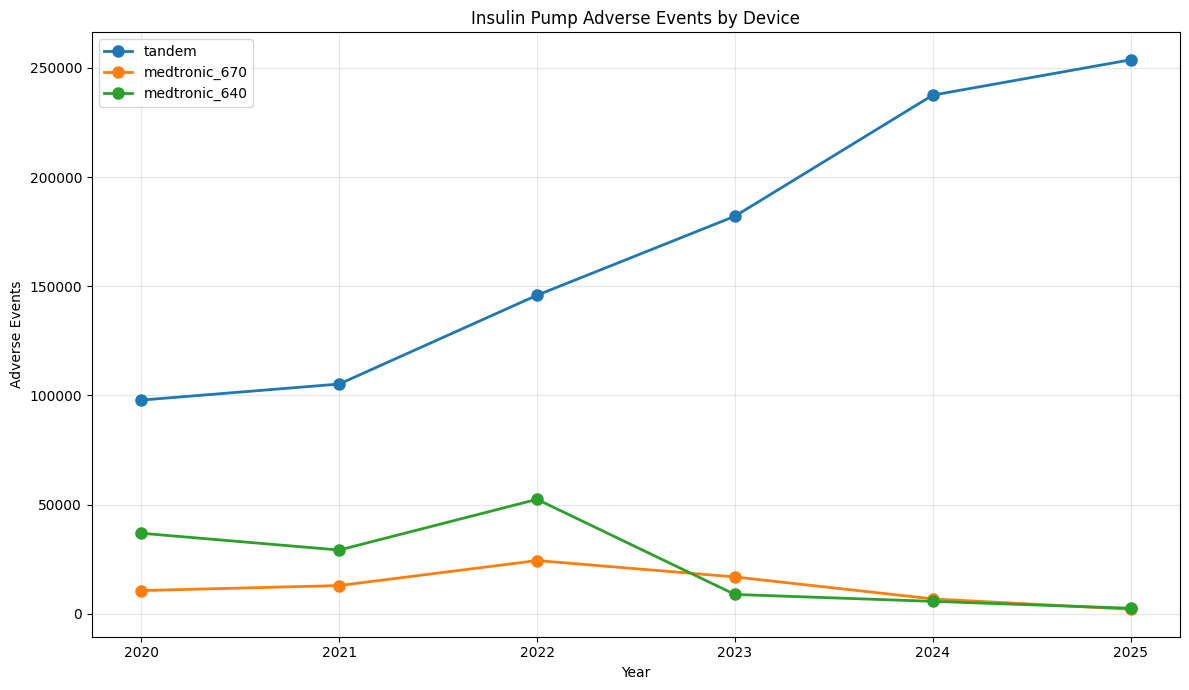

In [6]:
# Step 5: Temporal trend comparison
trends = db.get_trends_by_year(pumps)

plt.figure(figsize=(12, 7))
for device in pumps['search_group'].unique():
    device_trends = trends[trends['search_group'] == device]
    plt.plot(device_trends['year'], device_trends['event_count'], 
             marker='o', label=device, linewidth=2, markersize=8)

plt.xlabel('Year')
plt.ylabel('Adverse Events')
plt.title('Insulin Pump Adverse Events by Device')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
# Step 6: Patient outcome analysis
enriched = db.enrich_with_patient_data(pumps)
outcome_summary = db.count_unique_outcomes_per_report(enriched)

# Note: count_unique_outcomes_per_report automatically preserves columns that are 
# consistent within each MDR_REPORT_KEY group (like search_group), so no merge needed

print("Patient outcomes by device:\n")
for device in pumps['search_group'].unique():
    device_outcomes = outcome_summary[outcome_summary['search_group'] == device]
    total = len(device_outcomes)
    
    if total > 0:
        death = device_outcomes['unique_outcomes'].apply(lambda x: 'D' in x).sum()
        hosp = device_outcomes['unique_outcomes'].apply(lambda x: 'H' in x).sum()
        
        print(f"{device}:")
        print(f"  Total: {total}")
        print(f"  Death: {death} ({100*death/total:.1f}%)")
        print(f"  Hospitalization: {hosp} ({100*hosp/total:.1f}%)")
        print()

Joined 1230420 patient records
Patient outcomes by device:

tandem:
  Total: 1022358
  Death: 92 (0.0%)
  Hospitalization: 7176 (0.7%)

medtronic_670:
  Total: 73791
  Death: 145 (0.2%)
  Hospitalization: 3891 (5.3%)

medtronic_640:
  Total: 135642
  Death: 116 (0.1%)
  Hospitalization: 100 (0.1%)



## Workflow 2: Temporal Signal Detection

Identify unusual spikes in adverse events using statistical process control.

In [8]:
# Step 1: Get device events over extended time period
device = db.search_by_device_names('insulin pump', start_date='2019-01-01')
print(f"Total events: {len(device)}")

Total events: 1520832


In [9]:
# Step 2: Calculate monthly event counts
device['month'] = pd.to_datetime(device['DATE_RECEIVED']).dt.to_period('M')
monthly_counts = device.groupby('month').size().reset_index(name='event_count')
monthly_counts['month'] = monthly_counts['month'].dt.to_timestamp()

print(f"Months tracked: {len(monthly_counts)}")
print(f"\nSummary statistics:")
print(monthly_counts['event_count'].describe())

Months tracked: 84

Summary statistics:
count       84.000000
mean     18105.142857
std       5933.841723
min       7959.000000
25%      13924.750000
50%      17344.000000
75%      21426.000000
max      39457.000000
Name: event_count, dtype: float64


In [10]:
# Step 3: Calculate control limits (mean ± 3 SD)
mean_count = monthly_counts['event_count'].mean()
std_count = monthly_counts['event_count'].std()

ucl = mean_count + 3 * std_count  # Upper control limit
lcl = max(0, mean_count - 3 * std_count)  # Lower control limit

print(f"Control limits:")
print(f"Mean: {mean_count:.1f}")
print(f"Upper control limit: {ucl:.1f}")
print(f"Lower control limit: {lcl:.1f}")

# Identify potential signals
signals = monthly_counts[
    (monthly_counts['event_count'] > ucl) | 
    (monthly_counts['event_count'] < lcl)
]

print(f"\nMonths with potential signals: {len(signals)}")
if len(signals) > 0:
    print(signals[['month', 'event_count']])

Control limits:
Mean: 18105.1
Upper control limit: 35906.7
Lower control limit: 303.6

Months with potential signals: 2
        month  event_count
41 2022-06-01        39457
42 2022-07-01        38850


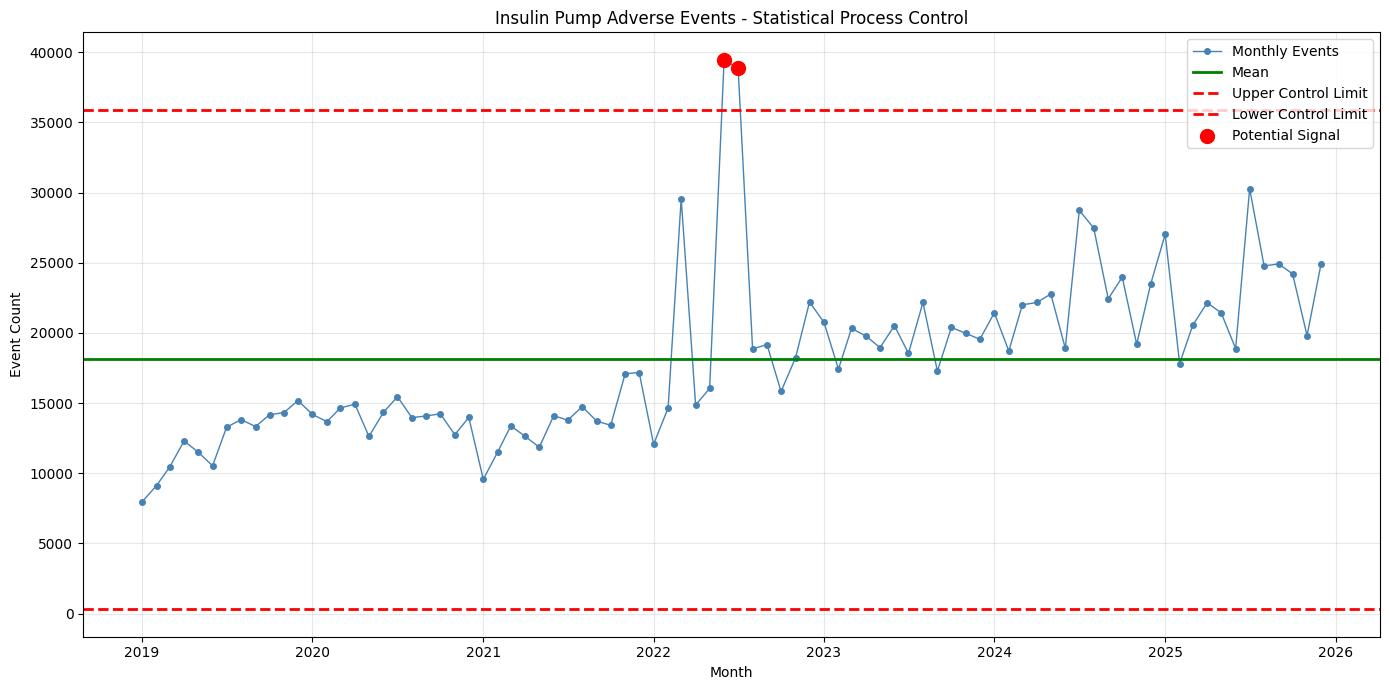

In [11]:
# Step 4: Control chart visualization
plt.figure(figsize=(14, 7))

plt.plot(monthly_counts['month'], monthly_counts['event_count'], 
         marker='o', linewidth=1, markersize=4, label='Monthly Events', color='steelblue')

plt.axhline(y=mean_count, color='green', linestyle='-', linewidth=2, label='Mean')
plt.axhline(y=ucl, color='red', linestyle='--', linewidth=2, label='Upper Control Limit')
plt.axhline(y=lcl, color='red', linestyle='--', linewidth=2, label='Lower Control Limit')

if len(signals) > 0:
    plt.scatter(signals['month'], signals['event_count'], 
                color='red', s=100, zorder=5, label='Potential Signal')

plt.xlabel('Month')
plt.ylabel('Event Count')
plt.title('Insulin Pump Adverse Events - Statistical Process Control')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Workflow 3: Failure Mode Analysis

Identify common failure patterns using narrative text analysis.

In [12]:
# Step 1: Get device events
devices = db.search_by_device_names('catheter', start_date='2021-01-01')
print(f"Total events: {len(devices)}")

Total events: 269722


In [13]:
# Step 2: Sample narratives (avoid excessive API calls)
sample_keys = devices['MDR_REPORT_KEY'].sample(min(300, len(devices))).tolist()
narratives = db.get_narratives(sample_keys)

print(f"Retrieved {len(narratives)} narratives")

Retrieved 851 narratives


In [14]:
# Step 3: Search for failure mode keywords
keywords = {
    'fracture': ['fracture', 'break', 'broke', 'broken', 'fragment'],
    'disconnect': ['disconnect', 'detach', 'separate'],
    'leak': ['leak', 'leaking'],
    'occlusion': ['occlude', 'occlusion', 'blocked', 'clog'],
    'malfunction': ['malfunction', 'failed', 'failure']
}

failure_counts = {}
for failure_mode, terms in keywords.items():
    pattern = '|'.join(terms)
    count = narratives['FOI_TEXT'].str.contains(
        pattern,
        case=False,
        na=False,
        regex=True
    ).sum()
    failure_counts[failure_mode] = count

print("Failure mode mentions:")
failure_df = pd.DataFrame.from_dict(failure_counts, orient='index', columns=['count'])
failure_df['percentage'] = 100 * failure_df['count'] / len(narratives)
failure_df = failure_df.sort_values('count', ascending=False)
print(failure_df)

Failure mode mentions:
             count  percentage
malfunction    149   17.508813
fracture       118   13.866040
leak           105   12.338425
disconnect      65    7.638073
occlusion       43    5.052879


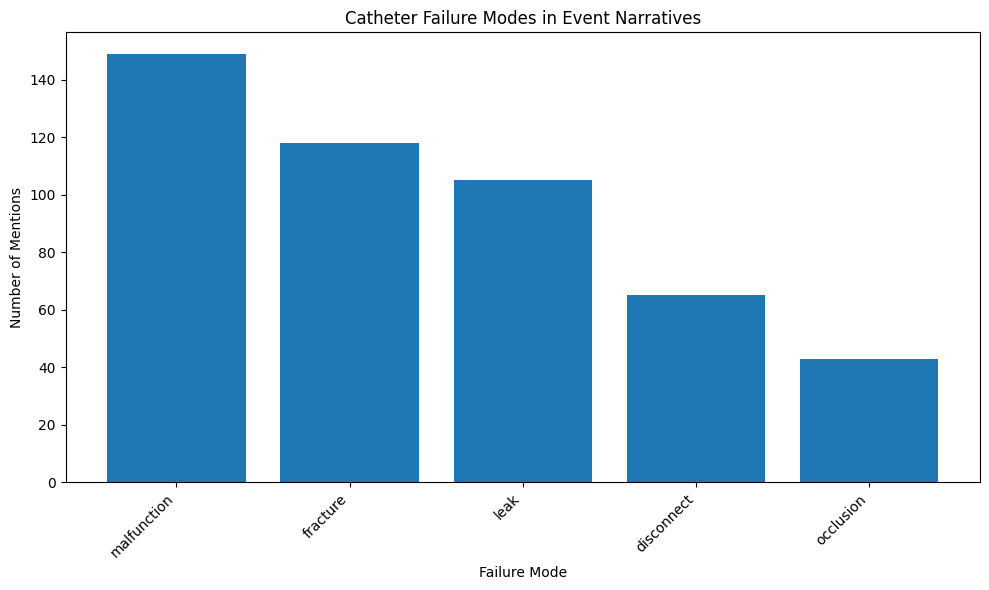

In [15]:
# Visualize failure modes
plt.figure(figsize=(10, 6))
plt.bar(failure_df.index, failure_df['count'])
plt.xlabel('Failure Mode')
plt.ylabel('Number of Mentions')
plt.title('Catheter Failure Modes in Event Narratives')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Exporting Results

Export analysis results for publication or further analysis:

In [16]:
# Export comparative analysis data
pumps.to_csv('insulin_pump_comparison.csv', index=False)

# Export trends
trends.to_csv('insulin_pump_trends.csv', index=False)

# Export summary statistics
pd.DataFrame(summary['counts'], index=[0]).to_csv('pump_summary_counts.csv', index=False)

print("Results exported:")
print("  - insulin_pump_comparison.csv")
print("  - insulin_pump_trends.csv")
print("  - pump_summary_counts.csv")

Results exported:
  - insulin_pump_comparison.csv
  - insulin_pump_trends.csv
  - pump_summary_counts.csv


## Cleanup

In [17]:
db.close()

## Summary

### Key Workflow Principles:

1. **Always check and handle EVENT_KEY duplication**
2. **Use statistical tests for comparisons** (not just counts)
3. **Visualize trends over time** to identify patterns
4. **Enrich with patient outcomes** when relevant
5. **Search narratives for failure patterns** when investigating specific issues
6. **Export results in reproducible formats**

### Analysis Checklist:

- [ ] Deduplicate by EVENT_KEY if rate > 5%
- [ ] Calculate summary statistics by group
- [ ] Perform statistical tests for comparisons
- [ ] Visualize temporal trends
- [ ] Analyze patient outcomes
- [ ] Export raw data and summaries

### Best Practices:

- Start with exploratory grouped search
- Check data quality (duplication, completeness)
- Use appropriate statistical tests
- Visualize results clearly
- Document methodology
- Export reproducible results